In [1]:
# mainline lib
from os import path, walk
from matplotlib import pyplot as plt
from matplotlib import patches
import random as rd
from tqdm import tqdm
import cv2 as cv
import numpy as np

# custom lib
from alprLib.PlateBoundingBox import PlateBoundingBox

In [2]:
DATASET_PATH = "./archive"
ANNOTATIONS_PATH = path.join(DATASET_PATH, "annotations")
IMAGES_PATH = path.join(DATASET_PATH, "images")

## Random Sample

Image shape: (225, 400, 4)


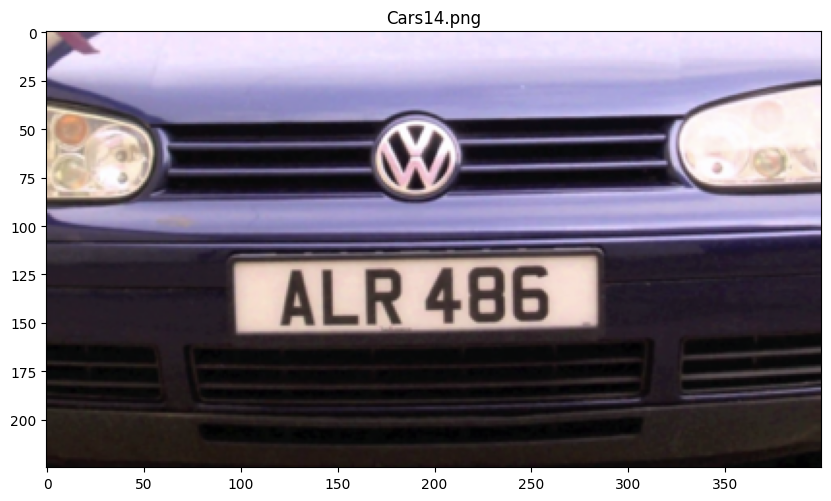

In [3]:
image_filenames = list(walk(IMAGES_PATH))
image_filename = rd.choice(image_filenames[0][2])
image_path = path.join(image_filenames[0][0], image_filename)
img = plt.imread(image_path)
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title(image_filename)
ax.imshow(img)
print('Image shape: {}'.format(img.shape))

In [4]:
annotation = image_filename.split('.')[0] + '.xml'
annotation_path = path.join(ANNOTATIONS_PATH, annotation)
print('Annotation path: {}'.format(annotation_path))

with open(annotation_path, 'r') as f:
    print(f.read())

Annotation path: ./archive/annotations/Cars14.xml

<annotation>
    <folder>images</folder>
    <filename>Cars14.png</filename>
    <size>
        <width>400</width>
        <height>225</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>licence</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>94</xmin>
            <ymin>118</ymin>
            <xmax>274</xmax>
            <ymax>163</ymax>
        </bndbox>
    </object>
</annotation>


In [5]:
plate = PlateBoundingBox(annotation_path)
plate.describe()

PlateBoundingBox
xml_path: ./archive/annotations/Cars14.xml
xmin: 94
ymin: 118
xmax: 274
ymax: 163
width: 180
height: 45
center: (184.0, 140.5)
area: 8100



## Draw Bounding Box on image

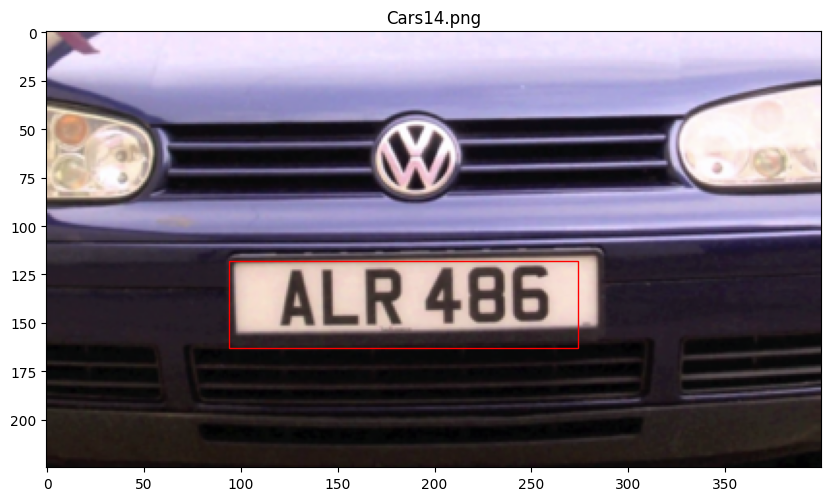

In [6]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title(image_filename)
ax.imshow(img)
rect = patches.Rectangle((plate.xmin, plate.ymin), plate.width, plate.height, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

## Load Everything in RAM

In [7]:
raw_imgs = []
annotations = []
image_filenames = list(walk(IMAGES_PATH))
for image_filename in tqdm(image_filenames[0][2]):
    image_path = path.join(image_filenames[0][0], image_filename)
    img = cv.imread(image_path)
    raw_imgs.append(img)

    annotation = image_filename.split('.')[0] + '.xml'
    annotation_path = path.join(ANNOTATIONS_PATH, annotation)
    annotations.append(PlateBoundingBox(annotation_path))

100%|██████████| 433/433 [00:03<00:00, 118.87it/s]


## Gray Scale

In [8]:
# random index
random_index = rd.randint(0, len(raw_imgs) - 1)
random_index

198

In [9]:
grayscale_imgs = []

for image in raw_imgs:
    grayscale_img = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    blurred_img = cv.GaussianBlur(grayscale_img, ksize=(3, 3), sigmaX=0)  # gaussian blur 

    thresh_img = cv.adaptiveThreshold(
        blurred_img, 
        maxValue=255.0, 
        adaptiveMethod=cv.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv.THRESH_BINARY_INV, 
        blockSize=19, 
        C=9
    )

    canny_img = cv.Canny(thresh_img, threshold1=100, threshold2=200)

    grayscale_imgs.append(canny_img)

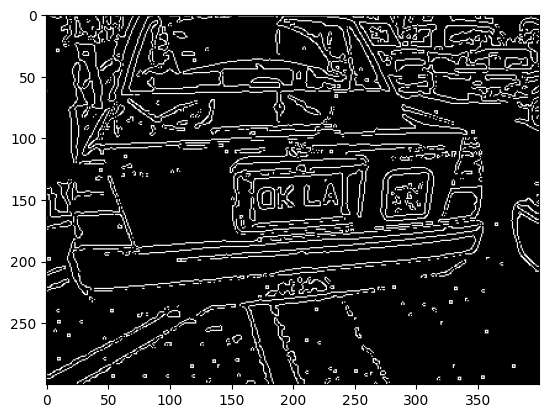

In [10]:
plt.imshow(grayscale_imgs[random_index], cmap='gray')

## Bounding Box extraction

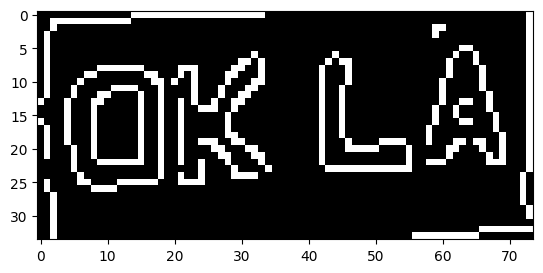

In [11]:
plates = []

for i in range(len(grayscale_imgs)):
    img = grayscale_imgs[i]
    plate = annotations[i]
    xmin = plate.xmin
    ymin = plate.ymin
    xmax = plate.xmax
    ymax = plate.ymax
    plates.append(img[ymin:ymax, xmin:xmax])

plt.imshow(plates[random_index], cmap='gray')

## Perspective Correction

idea: detect horizontal lines to compute homomorphism

In [20]:
# perspective correction of plates
plate_lines = []
for i in range(len(plates)):
    plate = plates[i]

    line_image = np.zeros_like(plate)  # creating a blank to draw lines on
    
    lsd = cv.createLineSegmentDetector(0)

    lines, width, prec, nfa = lsd.detect(plate)
    if lines is None:
        print("No line segments detected.")
        continue
    
    edgeMap = lsd.drawSegments(line_image, lines)[..., -1]

    plate_lines.append(edgeMap)

No line segments detected.
No line segments detected.
No line segments detected.


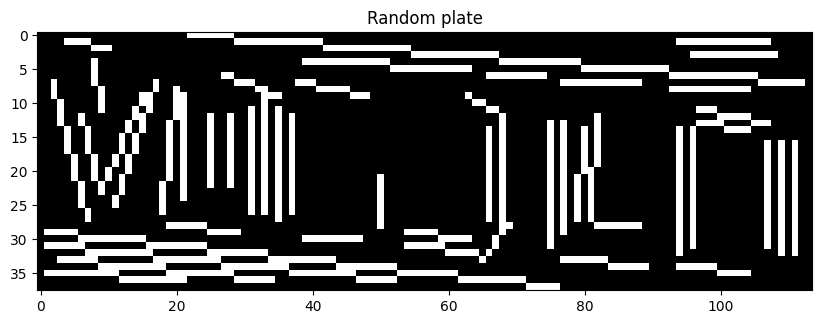

In [49]:
# show a random plate
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title('Random plate')
ax.imshow(rd.choice(plate_lines), cmap='gray')

## Contours

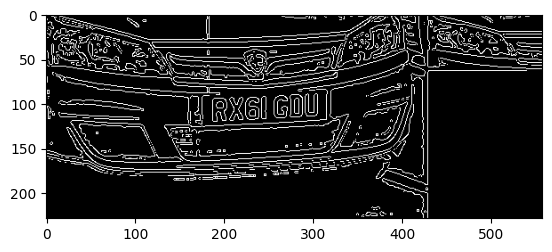

In [ ]:
contours_imgs = []

img_contours = []

for image in grayscale_imgs:
    contours, _= cv.findContours(
        image, 
        mode=cv.RETR_LIST, 
        method=cv.CHAIN_APPROX_SIMPLE
    )
    img_contours.append(contours)

    img_contour = np.zeros(image.shape, dtype=np.uint8)

    cv.drawContours(img_contour, contours=contours, contourIdx=-1, color=(255, 255, 255))

    contours_imgs.append(img_contour)


plt.imshow(contours_imgs[random_index], cmap='gray')

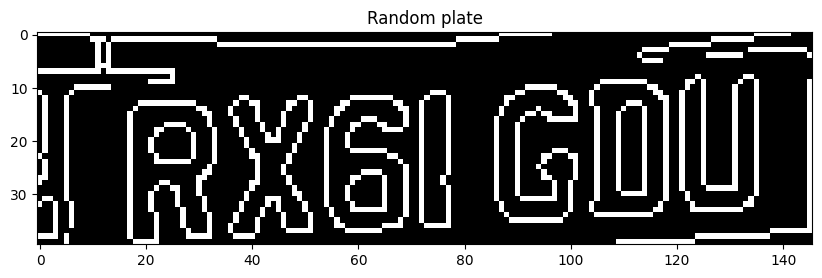

In [ ]:
# show a random plate
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title('Random plate')
ax.imshow(plates[random_index], cmap='gray')

## Contours to Rectangles

Once we have the image of the plate, we can find the contours of the characters so that we can later extract them and feed them to the model.

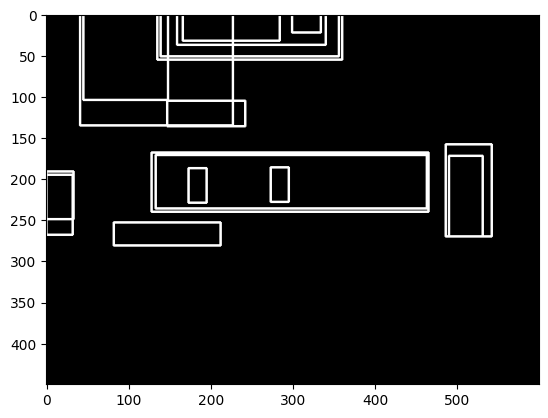

In [ ]:
bb_imgs = []

for random_index in range(len(img_contours)):
    img_contour = img_contours[random_index]
    bb_img = np.zeros(contours_imgs[random_index].shape, dtype=np.uint8)
    for contour in img_contour:
        x, y, w, h = cv.boundingRect(contour)
        if w > 20 and h > 20:
            cv.rectangle(bb_img, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)

    bb_imgs.append(bb_img)

plt.imshow(rd.choice(bb_imgs), cmap='gray')